# Assignment 2
Collaborators (Name, study id, github handle): <br />
August Hertz Bugge - s194350 - libze<br />
David Bro Ludvigsen - s204102 - davidAlvaBro<br />
Sebastian Nicolai Fabricius Grut  - s204150 - Sebastiannfg

Github : https://github.com/davidAlvaBro/comsocsci2023.git 

#### Contributions 
We collaborated as a group. We have had weekly meetings where we completed the weekly assignments together - everything has been discussed and made together. 


In [1]:
# Imports that will be used through the notebook
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netwulf
import copy
# import community

DATA_PATH = "my_data/"

## 1 Mixing Patterns and Assortativity

### For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [2]:
# Load the graph from week 4
CSS_graph = nx.read_graphml(DATA_PATH + 'CSS_graph.graphml')

# Only work on the largest connected component
CSS_graph_cc = sorted(nx.connected_components(CSS_graph), key=len, reverse=True)
CSS_giant = CSS_graph.subgraph(CSS_graph_cc[0])


In [3]:
# Function to calculate the fraction of neighbors that have the same attribute value
def get_matching_att(graph, att):
    """
    A function that calculates the fraction of neighbors that have the same attribute value
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns:
        match_frac (dict): A dictionary with the fraction of neighbors that have the same attribute value
    """
    match_frac = {}
    for node in graph.nodes:
        counter = 0
        neighbors = len(list(graph.neighbors(node)))

        if neighbors == 0: match_frac[node] = 0 # Have to check this, otherwise devising by zero

        else:
            for neighbor in graph.neighbors(node):
                # Check if the attribute value is the same for the node and the neighbor
                if nx.get_node_attributes(graph, att)[neighbor] == nx.get_node_attributes(graph, att)[node]:
                    counter += 1

            match_frac[node] = counter / neighbors

    return match_frac


In [4]:
# Get the average fraction of neighbors that have the same attribute value 
top_field_fracs = get_matching_att(CSS_giant, 'att2')

print(f"Average across all nodes {np.mean(list(top_field_fracs.values()))}")

Average across all nodes 0.4612019436773343


### Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

In [5]:
# Function that shuffles the attribute values of a graph
def shuffle_node_att(graph, att):
    """ 
    A function that shuffles the attribute values of a graph
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns: 
        graph (nx.Graph): The graph with shuffled attributes
    """
    # Make dictionary with shuffled attributes
    shuffled_atts = nx.get_node_attributes(graph, att)
    temp = list(shuffled_atts.values())
    random.shuffle(temp)
    new_atts = dict(zip(shuffled_atts, temp))

    # Set the shuffled attributes
    nx.set_node_attributes(graph, new_atts, att)
    
    return graph


In [6]:
# Make a copy of the graph and shuffle the attribute values
CSS_giant_copy = copy.deepcopy(CSS_giant)
CSS_giant_copy = shuffle_node_att(CSS_giant_copy, 'att2')

print(f"When the fields are randomly assigned, on average an auther has {np.mean(list(get_matching_att(CSS_giant_copy, 'att2').values()))} of their neighbors in the same field")


When the fields are randomly assigned, on average an auther has 0.30896528283141833 of their neighbors in the same field


### Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

In [7]:
try: 
    distribution = np.load(DATA_PATH + "avg_same_field_distribution.npy")
except: 
    # Shuffles the graph attributes N times and stores the distribution of the average fraction of neighbors that have the same attribute value
    N = 10 # TODO run this with more data 
    distribution = np.zeros(N)
    for i in tqdm(range(N)):
        CSS_giant_copy = shuffle_node_att(CSS_giant_copy, 'att2')
        avg = np.mean(list(get_matching_att(CSS_giant_copy, 'att2').values()))
        distribution[i] = avg 

    np.save(DATA_PATH + "avg_same_field_distribution.npy", distribution)

In [8]:
# Load the distribution if not in memory 
if 'distribution' not in locals():
    distribution = np.load(DATA_PATH + "avg_same_field_distribution.npy")

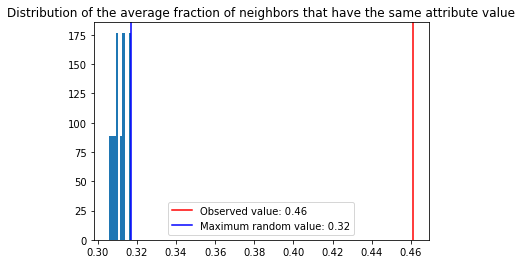

In [9]:
# Setup for plot
bins = 10
avg_value = np.mean(list(top_field_fracs.values()))

# Plot the distribution
figure, ax = plt.subplots(1)

ax.hist(distribution, density=True, bins=bins)
ax.axvline(x=avg_value, color='r', label=f"Observed value: {avg_value:.2f}")
ax.axvline(x=np.max(distribution), color='b', label=f"Maximum random value: {np.max(distribution):.2f}")
ax.legend()
ax.title.set_text("Distribution of the average fraction of neighbors that have the same attribute value")

plt.show()

In the plot we see the distribution of the average fraction of coauthers of the same field each author has. The red line indicates our observed dataset as one datapoint, while the blue line indicates the largest value in the randomly generated datasets. 

We see that the observed average fraction of authors with the same field as the author in question is 0.46, but nothing close to this value has ever occured in the randomly generated data with 300 samples, this implies that the distribution of it stems from is significantly different than the randomly generated distribution. This is seen in the plot by the largest random value (the blue vertical line) being smaller than the observed value (the blue vertical line). 

In other words, authors tend to work together with authors of the same field. 

### Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain?

We use the formula stated; 
$$r = \frac{Tr(e) - ||e^2||}{1 - ||e^2||}.$$

First we compute $e$, that is we count each edge (twice) that goes from each author group to another to set up the matrix. Next we compute the trace, and at last we square the matrix and sum it. 

In [10]:
# This method generates the matrix used to calculate the association for a given attribute. 
# It is correosponding to the function attribute_mixing_matrix in the networkx package
def get_mixing_matrix(graph, att):
    """
    A function that calculates the matrix of the fraction of edges between fields.
    Assumes that the graph is undirected.
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns:
        E (np.array): The matrix of the fraction of edges between fields
        list_of_fields (dict): A dictionary with the fields as keys and the index of the field in the matrix as values
    """
    # Get dimensions of matrix
    list_of_fields = {field: i for i, field in enumerate(set(nx.get_node_attributes(graph, att).values()))}
    E = np.zeros((len(list_of_fields), len(list_of_fields)))

    # Fill the matrix/dictionary
    for edge in tqdm(graph.edges):
        # Get the field of the node at the ends of the edge 
        node_1_field = nx.get_node_attributes(graph, att)[edge[0]]
        node_2_field = nx.get_node_attributes(graph, att)[edge[1]]
        # To make the matrix symetric, we add the value to both fields
        E[list_of_fields[node_1_field], list_of_fields[node_2_field]] += 1
        E[list_of_fields[node_2_field], list_of_fields[node_1_field]] += 1
    
    E = E / (2*graph.number_of_edges())

    return E, list_of_fields


In [11]:
# Check if it works
mixing_matrix, _ = get_mixing_matrix(CSS_giant, 'att2')
mixing_matrix_2 = nx.attribute_mixing_matrix(CSS_giant, 'att2')

# Only certain checks 
print(np.trace(mixing_matrix), np.sum(mixing_matrix))
print(np.trace(mixing_matrix_2), np.sum(mixing_matrix_2)) 

 26%|██▌       | 3384/13045 [00:46<02:13, 72.38it/s]

In [ ]:
# Calculate the association for fields
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
print(f"The association for fields is {calculate_assortiative_coef(mixing_matrix):.2f}")
print(f"The association for fields is {nx.attribute_assortativity_coefficient(CSS_giant, 'att2'):.2f}, calculated with the mx library")

The association for fields is 0.17
The association for fields is 0.17
The association for fields is 0.17, calculated with the mx library


### Is the graph assortative with respect to the degree?

TypeError: 'str' object is not callable

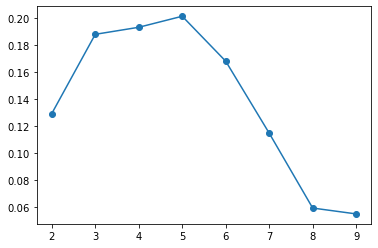

In [ ]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 10
assosiations = np.zeros(max_threshold - 2)

for threshold in range(2, max_threshold):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in CSS_giant.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(CSS_giant.degree(edge[0]), threshold)
        j = get_i(CSS_giant.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*CSS_giant.number_of_edges())
    
    # Store the assosiation
    assosiations[threshold - 2] = calculate_assortiative_coef(E)

plt.plot(range(2, max_threshold), assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Assosiation")
plt.title("Assosiation for different thresholds")

From this graph we can see that there is an assosiation when the "high degrees" are relatively small numbers, but the assosiation becomes negliable when "high degress" are large (above 8). 

When we created the dataset we started with an amount of authors and looked at all of their papers. These original authors will have many coauthors because the "spawned" the rest of the dataset. This introduces some noise in who has a high degree. 

#### TODO expand on this 

## Communities - Exercise 2, Zachary's karate club 

### Visualize the graph using netwulf. Set the color of each node based on the club split.

In [ ]:
# TODO maybe rewrite this? we could use the club parameter in the karate club graph
# Load the graph
karclub_data = nx.karate_club_graph()
club_membership = nx.get_node_attributes(karclub_data, "club")

#setting the colors of different club nodes
colors = {}
clubs = []#For use later
mrhi_members = []
officer_members = []

for node in range(len(karclub_data.nodes)):
    if club_membership[node] == 'Mr. Hi': 
        colors[node] = "blue"
        mrhi_members.append(node)
    else:
        colors[node] = "red"
        officer_members.append(node)

clubs.append(mrhi_members)
clubs.append(officer_members)
nx.set_node_attributes(karclub_data,colors,"color")

# Visualize the graph with netwulf 
netwulf.interactive.visualize(karclub_data,config={"Node color": "color"})

![Alt text](https://file%2B.vscode-resource.vscode-cdn.net/c%3A/Users/david/Desktop/Computational%20social%20science/comsocsci2023/my_data/netwulf.png?version%3D1679758749082)

### Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

This is done with the formula (9.12) from the book, 
$$M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]. $$

In [ ]:
#Modularity function
def modularity(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = {community: 0 for community in range(num_of_communities)}
    tot_degree = {community: 0 for community in range(num_of_communities)}
    
    # Dictionary to map node IDs to community IDs
    communities_lookup = {node: community for community, nodes in enumerate(communities) for node in nodes}

    # Count the number of links within each community and the total degree of each community
    for (node_1, node_2) in G.edges():
        node_1_community = communities_lookup[node_1]
        node_2_community = communities_lookup[node_2]
        
        # Since we go through all edges, we also get the degree of all nodes
        tot_degree[node_1_community] += 1
        tot_degree[node_2_community] += 1
        
        # If the nodes are in the same community, add one to that community's link count
        if node_1_community == node_2_community:
            links_in_community[node_1_community] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M


### Explain in your own words the concept of modularity

The formula to calculate the modularity is, as stated, given by, 
$M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]$,  and it tells us the degree in which the network is modular, given a partition into communities. 

It measures the difference between the number of edges within each community, and the expected number of edges given a random distribution. The value, $M \in [-1, 1]$, where positive values express that the communities have more links within them, then they would at random, while negative values show the opposite. 

If it is close to one, we likely have a dense community structure and the partition is close to having found these communities. If it is close to 0, we perhaps have a more homogenous structure without any clear structure, or we have a partition that does not reflect the true communities. At last values close to -1 tells us that the partition used have divided the graph poorly into communities, and that a random distribution would form stronger communities with this partition. 

Modularity is a useful metric in the analysis of complex networks for this reason.

### Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [ ]:
kar_club_modularity = modularity(karclub_data, clubs)
print(f"The modularity of the karate club graph is {kar_club_modularity:.2f}")

### Implementation of the double edge swap algorithm 

In [ ]:
# TODO look at this again, especially the part where do this "if u != v and v != x:"
#Random Edge swap function

def edge_swap(G, N):
    """
    create a copy of G with N swapped edges

    Parameters:
        - G: the given graph
        - N: how many edges we want swapped

    Returns:
        - G_copy: a copy of graph g with N edges swapped at random
    """
    
    # Make a copy of the original network, to not change the original
    G = copy.deepcopy(G)
    
    # Perform at least N edge swaps
    edges_swapped = 0
    while edges_swapped <= N:
        # Choose two random edges
        edges = random.sample(G.edges(), 2)
        (u, v) = edges[0]
        (x, y) = edges[1]
        # Check that we will not link a node to itself
        # We believe that there was an error in the instructions
        # That it is not meant to say u != v, as this is trivial and can't happen
        # Instead it is vital to check that u != y such that we don't link u to itself
        if u != y and v != x:
            # Check if the edges (u,y) and (x,v) exist
            if not G.has_edge(u, y) and not G.has_edge(x, v):
                # Swap the edges 
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, y)
                G.add_edge(x, v)

                #Counter for number of swaps
                edges_swapped += 1

    return G

### Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [ ]:
#looping to see if every node has the same degree

karclub_random = edge_swap(karclub_data, 100)

for i in karclub_data.nodes():
    #If the loop does not return anything, all the degrees are the same
    
    if karclub_data.degree(i) == karclub_random.degree[i]:
        pass
    else:
        print("There is a node with a different degree!")

### Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [ ]:
# Set seed in the interest of repeatability
random.seed(69420)
# A list that will contain a thousand randomized modularities
rand_modularities = np.zeros((1000))

#The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
#Here we use the previously defined modularity and edge_swap funtions
for i in tqdm(range(1000)):
    rand_karclub = edge_swap(karclub_data, 100)
    rand_modularities[i] = (modularity(rand_karclub, clubs))


### Compute the average and standard deviation of the modularity for the random network.

In [ ]:
mean_rand_mods = np.mean(rand_modularities)
std_rand_mods = np.std(rand_modularities)

print("The mean of the thousand edge swapped modularities is " + str(mean_rand_mods))
print("The standard deviation of the thousand edge swapped modularities is " + str(std_rand_mods))

### Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

In [ ]:
"Plotting a histogram over the distribution values for"

plt.hist(rand_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities')
plt.axvline(x=kar_club_modularity, color = "red")
plt.show()

### Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

As we can see, the karate club dataset partitioning is significantly different from the random modularities generated by the randomization experiment, which tells us that we have a good partitioning. 

The point of prserving the nodes degree is to ensure any change was due to a difference in edge distribution, rather than a change in the structure of the network. Changing the degree distribution can significantly change the structure of the network. However, if we simply move some edges around while preserving the degree distribution, we ensure the change is not due to a change in the degree distribution. The point of the randomization experiment is to test the modularity of the network, to see if it is significantly different from what we would see if the edges we're formed at random, given the same degree distribution.

### TODO check this 

## Communities - Exercise 3, CSS
We still work on the giant component in this section, as it does not really make sense to look at the communities of 